In [3]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt


In [4]:
# Function to load labelled data from the source folders 
def load_images(data_dir, size = (96,96)):
    labels = []
    images = []
    classes = sorted(os.listdir(data_dir))  # Get the folders/classes (labels)

    # Loop through all folders
    for idx, class_name in enumerate(classes):
        class_folder = os.path.join(data_dir, class_name)
        print('Loading class %s' %class_name)
        
        if os.path.isdir(class_folder):
            # Loop through each image file within the class folder
            for img_name in os.listdir(class_folder)[0:1000]:
                img_path = os.path.join(class_folder, img_name)

                try:
                    # Load the image, resize it, and convert to a numpy array
                    img = Image.open(img_path)
                    img = img.resize(size) # Resize in case there are images of different sizes and channels
                    img_array = np.array(img)

                    # Add the image to the list and its corresponding label (class index)
                    images.append(img_array)
                    labels.append(idx)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    
    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels, classes

In [5]:
def plot_class_distribution(y, dataset_name):
    # If one-hot encoded, convert back to class labels
    if len(y.shape) > 1 and y.shape[1] > 1:
        y = np.argmax(y, axis=1)
    
    class_counts = np.bincount(y)
    classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
    
    plt.bar(classes, class_counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.title(f'Class Distribution in {dataset_name} Set')
    plt.xticks(rotation=45)
    plt.show()
    
    print(f'Class counts in {dataset_name} set:', dict(zip(classes, class_counts)))

In [6]:
# Actually load the data from the folders
data_dir_train = '../data/seg_train'
data_dir_test = '../data/seg_test'

x_train, y_train, train_classes = load_images(data_dir_train, size=(96,96))
x_test, y_test, test_classes = load_images(data_dir_test,size=(96,96))

print(f"\nLoaded trian_images: {x_train.shape}")
print(f"Loaded train_labels: {y_train.shape}")
print(f"train_Classes: {train_classes}")

print(f"\nLoaded test_images: {x_test.shape}")
print(f"Loaded test_labels: {y_test.shape}")
print(f"test_Classes: {test_classes}")

Loading class buildings
Loading class forest
Loading class glacier
Loading class mountain
Loading class sea
Loading class street
Loading class buildings
Loading class forest
Loading class glacier
Loading class mountain
Loading class sea
Loading class street

Loaded trian_images: (6000, 96, 96, 3)
Loaded train_labels: (6000,)
train_Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

Loaded test_images: (3000, 96, 96, 3)
Loaded test_labels: (3000,)
test_Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [7]:
from sklearn.model_selection import train_test_split

# Manually split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

# Normalization
x_train, x_test, x_val = x_train / 255.0, x_test / 255.0, x_val / 255.0

# One hot encoding
y_train = to_categorical(y_train, 6) # Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
y_val = to_categorical(y_val, 6)
y_test = to_categorical(y_test, 6)

We need to check that the training data is well distributed

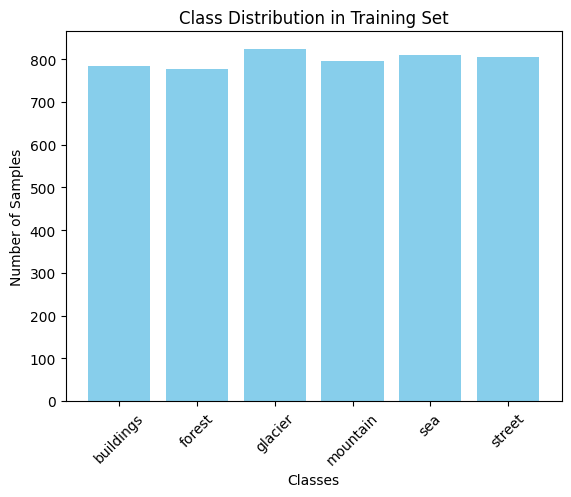

Class counts in Training set: {'buildings': np.int64(785), 'forest': np.int64(778), 'glacier': np.int64(824), 'mountain': np.int64(796), 'sea': np.int64(811), 'street': np.int64(806)}


In [8]:
# Training set
plot_class_distribution(np.argmax(y_train, axis=1), 'Training')

[0. 0. 0. 1. 0. 0.]


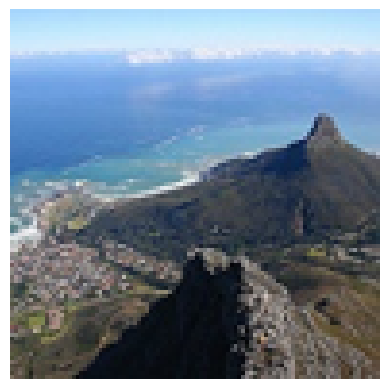

In [9]:
# Check if data is formatted correctly
print(y_train[0]) #Shows the one hot encoding and classification of the first image

plt.imshow(x_train[0])
plt.axis('off')
plt.show()

# **Model Training**

In [10]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

In [11]:
# Plot Losses Callback
import matplotlib.pyplot as plt
from IPython.display import clear_output
import keras

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.accuracy = []
        self.val_accuracy = []

        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get("loss"))
        self.val_losses.append(logs.get("val_loss"))
        self.accuracy.append(logs.get("accuracy"))
        self.val_accuracy.append(logs.get("val_accuracy"))
        self.i += 1

        clear_output(wait=True)
        
        # Plot losses
        plt.figure(figsize=(12, 6))
        
        # Subplot 1: Loss
        plt.subplot(1, 2, 1)
        plt.plot(self.x, self.losses, label="Train Loss")
        plt.plot(self.x, self.val_losses, label="Validation Loss")
        plt.title("Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        
        # Subplot 2: Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(self.x, self.accuracy, label="Train Accuracy")
        plt.plot(self.x, self.val_accuracy, label="Validation Accuracy")
        plt.title("Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        
        plt.tight_layout()
        plt.show()

In [12]:
# Define model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

efficient0 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(6, activation='softmax')
])

# Compile 
efficient0.summary()
efficient0.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 3, 3, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,057,257 (15.48 MB)

 Trainable params: 4,015,234 (15.32 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [13]:
# Data augmentation transformations

# Given the relatively small size of our dataset, we'll implement simple
# data augmentation techniques (rotation, zoom-in, etc) to expand the data
# and prevent overfitting. 

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

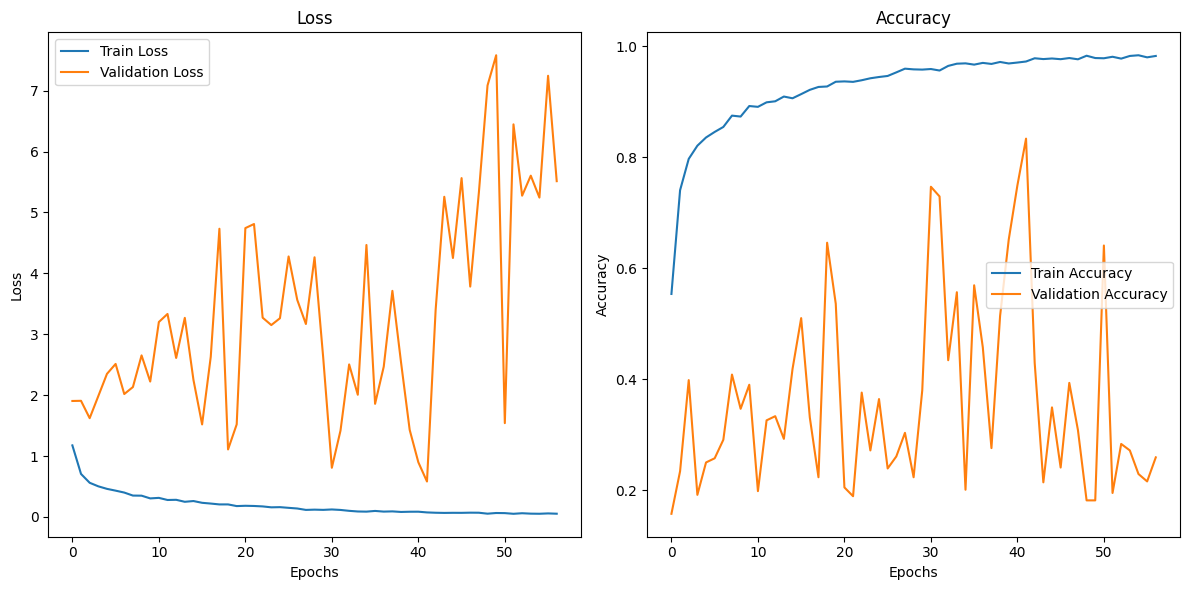

150/150 ━━━━━━━━━━━━━━━━━━━━ 34s 228ms/step - accuracy: 0.9837 - loss: 0.0529 - val_accuracy: 0.2592 - val_loss: 5.5143


In [14]:
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
plot_losses = PlotLosses()

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=15,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,
    patience=3,             
    min_lr=1e-6
)

# Train
history = efficient0.fit(
    datagen.flow(x_train, y_train, batch_size=32), 
    validation_data=(x_val, y_val),                
    epochs=60,                                     
    callbacks=[early_stopping,plot_losses],
)


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step


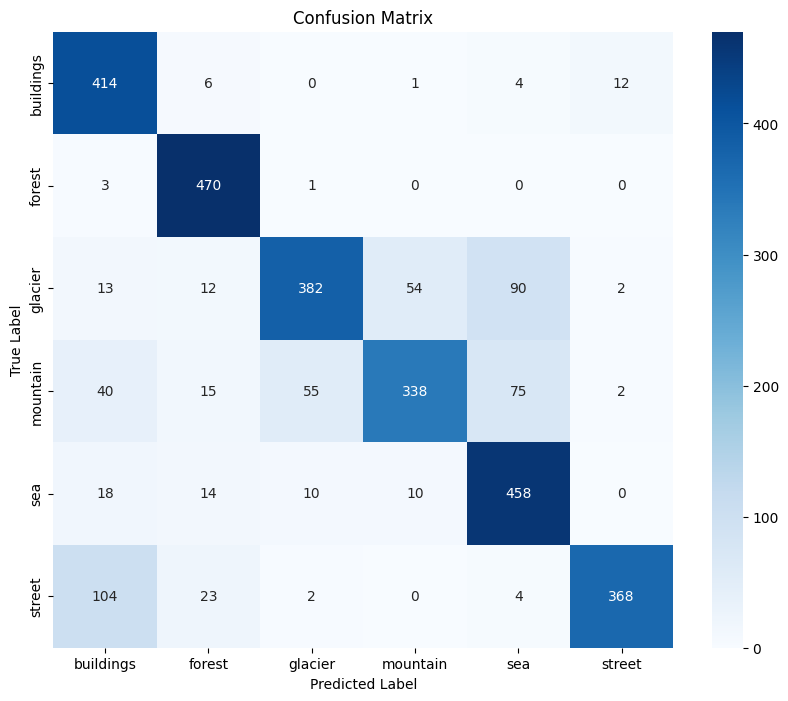

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8784 - loss: 0.4539
Test accuracy: 0.81


In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = efficient0.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

y_test_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

test_loss, test_accuracy = efficient0.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")


# **Predicting Images**
We are going to use the seg_pred dataset, which are unlabelled images, for the model to predict on.
We will then measure the accuracy and see how it compares to the test results.
EfficientNetB0 is our best model with 91% test accuracy, and we'll use 96x96 images to maintain consistency with training.

In [20]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import random
import matplotlib.pyplot as plt


In [22]:
# Function to load unlabeled data from the source folder
def load_unlabeled_images(data_dir, size=(96, 96)):
    images = []
    filenames = []

    # Loop through all files in the data_dir (no subdirectories)
    for img_name in os.listdir(data_dir):
        img_path = os.path.join(data_dir, img_name)

        try:
            # Skip hidden files (e.g., .DS_Store on macOS or Thumbs.db on Windows)
            if img_name.startswith('.') or not img_name.endswith(('.jpg', '.jpeg', '.png')):
                continue

            # Check if it's a valid image file
            if os.path.isfile(img_path):
                # Open the image, resize it, and convert to a numpy array
                img = Image.open(img_path)
                img = img.resize(size)  # Resize to the target size
                img_array = np.array(img)

                # Append the image and its filename to the lists
                images.append(img_array)
                filenames.append(img_name)
                print(f"Loaded image: {img_path}")  # Log the loaded images (can be removed later)

        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

    # Convert the list of images to a numpy array
    images = np.array(images)

    print(f"Total images loaded: {images.shape[0]}")  # Log the total number of images loaded
    return images, filenames

In [24]:
data_dir_pred = '../data/seg_pred'

# Load the unlabeled images
pred_images, filenames = load_unlabeled_images(data_dir_pred)
    
# Preprocess the images (normalize)
pred_images = pred_images / 255.0  # Normalizing to [0, 1] range if needed

Loaded image: ../data/seg_pred/63.jpg
Loaded image: ../data/seg_pred/24084.jpg
Loaded image: ../data/seg_pred/13628.jpg
Loaded image: ../data/seg_pred/3578.jpg
Loaded image: ../data/seg_pred/1409.jpg
Loaded image: ../data/seg_pred/23099.jpg
Loaded image: ../data/seg_pred/9041.jpg
Loaded image: ../data/seg_pred/4203.jpg
Loaded image: ../data/seg_pred/9727.jpg
Loaded image: ../data/seg_pred/77.jpg
Loaded image: ../data/seg_pred/24090.jpg
Loaded image: ../data/seg_pred/837.jpg
Loaded image: ../data/seg_pred/3544.jpg
Loaded image: ../data/seg_pred/13614.jpg
Loaded image: ../data/seg_pred/7044.jpg
Loaded image: ../data/seg_pred/17300.jpg
Loaded image: ../data/seg_pred/18033.jpg
Loaded image: ../data/seg_pred/5647.jpg
Loaded image: ../data/seg_pred/2128.jpg
Loaded image: ../data/seg_pred/4559.jpg
Loaded image: ../data/seg_pred/7050.jpg
Loaded image: ../data/seg_pred/12278.jpg
Loaded image: ../data/seg_pred/1347.jpg
Loaded image: ../data/seg_pred/7736.jpg
Loaded image: ../data/seg_pred/8405.j

In [33]:
def predict_and_display_random_images(model, data_dir_pred):
    # Predict the class probabilities
    predictions = model.predict(pred_images)

    # Get the predicted class labels (argmax to get the class with the highest probability)
    predicted_labels = np.argmax(predictions, axis=1)

    # Select 8 random indices to display 8 random images
    random_idxs = random.sample(range(len(pred_images)), 8)  # Get 8 random indices

    # Create a grid for displaying images (2 rows, 4 columns)
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))  # Create a 2x4 grid
    axes = axes.flatten()  # Flatten the axes array to easily iterate

    # Map the predicted label to its class name (replace with your actual class names)
    class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']  # Example class names

    # Loop through the selected 8 images
    for i, idx in enumerate(random_idxs):
        # Get the random image, predicted label, and filename
        random_image = pred_images[idx]
        predicted_label = predicted_labels[idx]
        filename = filenames[idx]
        
        predicted_class_name = class_names[predicted_label]

        # Display the image with the predicted label on top
        axes[i].imshow(random_image)
        axes[i].set_title(f"Predicted: {predicted_class_name}", fontsize=10, color='white', backgroundcolor='black')
        axes[i].axis('off')  # Hide the axes for each subplot

    # Show the plot with all 8 images
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

207/207 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step


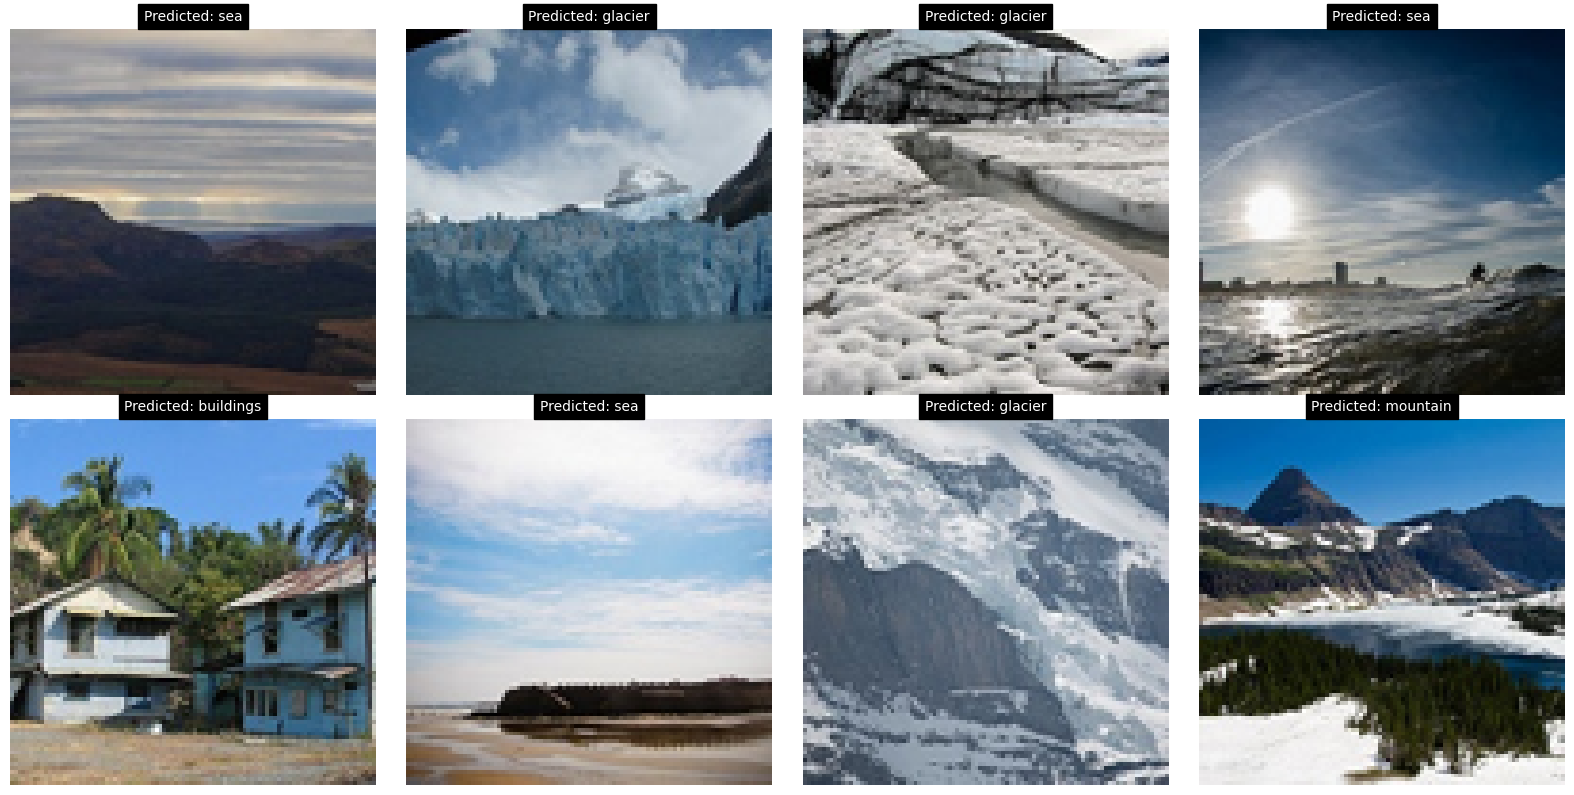

In [35]:
predict_and_display_random_images(efficient0, data_dir_pred)